# Log elemzés
Az okosotthon rendszer moduláris felépítésű, az egyes funkciókat különálló modulok valósítják meg. Az egyes modulok két nagy csoportra oszthatóak:
- bemenetek
- kimenetek
A bemenetek valamilyen szenzor típusú adatot szolgáltatnak a rendszer számára, tipikusan folytonos értéktartománnyal, míg a kimenetek tipikusan beavatkozók, amelyek valamilyen műveletet hajtanak végre, tipikusan be és kikapcsolnak, így értékük leggyakrabban kétértékű, 0 és 1.

A modulok működését a rendszer logolja. Ezen logok elérhetőek feldolgozásra.

Ezen munkafüzetben ezen logokat elemezzük, előfeldolgozzuk, hogy megvizsgáljuk, milyen összefüggések láthatóak az adatok közt, illetve megvizsgáljuk, hogy az adatok alapján lehet-e valamilyen szabályszerűséget felismerni, esetlegesen szabályt alkotni.

A vizsgálatokat standard adatelemzési módszerekkel hajtjuk végre, majd MI módszerekkel is keresünk összefüggéseket.

Az elemzésekhez a matplotlib standard könyvtárat használjuk megjelenítésre, de dinamikus adatvizualizációra, kísérletezgetésre a a matplotlib- integrációt használjuk, külön ablakos megjelenítésre, zoomolás dinamikus támogatására.
Az integrációt az aálbbi mintakód alapján valósítottuk meg: [GTK beágyazás - (matplotlib dokumentáció)](https://matplotlib.org/3.1.0/gallery/user_interfaces/embedding_in_gtk3_panzoom_sgskip.html)

Egy másik Jupiter notebookban a Holoviews rendszert használjuk dinamikus vizualizációra.



In [1]:
# Szükséges könyvtárak
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
# Az ablakok kezeléséhez használt könyvtárak
import gi
gi.require_version('Gtk', '3.0')
from gi.repository import Gtk

from matplotlib.figure import Figure
from matplotlib.backends.backend_gtk3agg import FigureCanvas
from matplotlib.backends.backend_gtk3 import (
    NavigationToolbar2GTK3 as NavigationToolbar)


Az alábbiakban betöltjük a pilot rendszerben rendelkezésre álló logokat és összefűzzük egyetlen adathalmazba, hogy kényelmesen tudjunk dolgozni vele, illetve elemezhessük az adatokat. A logolban található időbélyeg adatokat egyrészt meghagyjuk az adathalmazban datetime típusra konvertálva, illetve indexet is generálunk belőle (DateTimeIndex), amely segítségével idősoros adatokkal kényelmesen dolgozhatunk majd a továbbiakban.

In [3]:
# A pilot rendszerben elérhető logok betöltése
df_08 = pd.read_csv('./logs/msvlog1_201908.csv', sep=';', header=None, usecols=[0,1,7], names=['Variable', 'Value', 'Timestamp'])
df_09 = pd.read_csv('./logs/msvlog1_201909.csv', sep=';', header=None, usecols=[0,1,7], names=['Variable', 'Value', 'Timestamp'])
df_10 = pd.read_csv('./logs/msvlog1_201910.csv', sep=';', header=None, usecols=[0,1,7], names=['Variable', 'Value', 'Timestamp'])

In [4]:
# Az adatok összefűzése egyetlen adathalmazba
data = [df_08, df_09, df_10]
df = pd.concat(data)

In [5]:
# Segédfüggvények

# A logban a változókat leíró oszlop az alábbi formátumú:
# "modulnév_bemenet-kimenet típus változó típus_változónév"
# Az egyes szegmenseket "_" karakter választja el. 
#     modulnév:              egy rövid string, amely beazonosítja a modult,
#     bemenet-kimenet típus: egy karakter, i (input) vagy o (output)
#     változó típus:         egy karakter, d (digitális) vagy t (folytonos)
#     változónév:            az adott változó neve
#
# Példa:
# f_od_sziv_kaz: fűtés modul, digitális kimenet, sziv_kaz változó 
#                                                (szivattyú kazán vezérlés - 0 - kikapcsolva, 1 - bekapcsolva)

# A függvény a fenti formátumban lévő adatot megkapva szétbontja modul név, i/o, változónév hármasra. 
def split_variables(variable_string):
    module, io, variable = variable_string.split('_', 2)
    io = io[0]
    
    return pd.Series({
        'Module': module,
        'IO': io,
        'NVariable': variable
    })


In [6]:
df_newcols = df['Variable'].apply(split_variables)

df['datetime'] = pd.to_datetime(df['Timestamp'])
df['datetime_index'] = df['datetime'] 

df = pd.concat([df,df_newcols],axis=1)

df = df.set_index('datetime_index')

df.drop(['Timestamp'], axis=1, inplace=True)
df.drop(['Variable'], axis=1, inplace=True)

In [7]:
print(df)

                     Value            datetime Module IO  NVariable
datetime_index                                                     
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        kaz
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i     er_kaz
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        pa4
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        pa2
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ap1
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ap3
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ep1
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ep3
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        tp1
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  o   sziv_kaz
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  o    sziv_pf
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  o   sziv_rad
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07  

A feldolgozott oszlopokat eldobjuk, majd kimentjük a feldolgozott adatokat egy csv állományba, hogy a későbbiekben a transzformációkat ne kelljen megismételni, ezen állományból a feldolgozott adatok hatékonyan visszaolvashatóak.

In [8]:
df.to_csv('preprocessed_data_080910.csv', sep=';', header=True, index=True)

Annak érdekében, hogy már ezekkel az adatokkal dolgozzunk tovább, beolvassuk állományból az adatokat.

In [9]:
df = pd.read_csv('preprocessed_data_080910.csv', sep=';')
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_index'] = pd.to_datetime(df['datetime_index'])
df = df.set_index('datetime_index')

In [10]:
print(df)

                     Value            datetime Module IO  NVariable
datetime_index                                                     
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        kaz
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i     er_kaz
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        pa4
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        pa2
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ap1
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ap3
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ep1
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        ep3
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  i        tp1
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  o   sziv_kaz
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  o    sziv_pf
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07      f  o   sziv_rad
2019-08-18 11:37:07   0.00 2019-08-18 11:37:07  

Egy egszerű plottal megnézzük a sziv_kaz változó értékét 08.18 11 órakor.

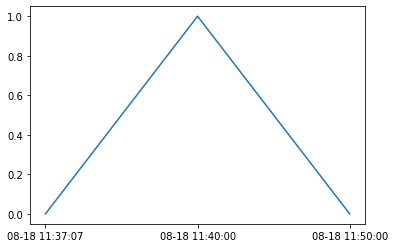

In [11]:
y = df.loc[df['NVariable'] == 'sziv_kaz'].Value
y = y[y.index.day == 18]
y = y[y.index.month == 8]
y = y[y.index.hour == 11]


x = y.index.strftime("%m-%d %H:%M:%S")

plt.plot(x,y)
plt.show()

Egy egyszerű hisztogram:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f818b52d2e8>]],
      dtype=object)

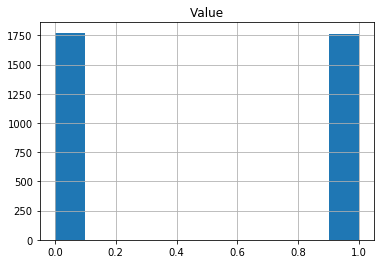

In [12]:
pd.DataFrame.hist(df.loc[df['NVariable'] == 'sziv_kaz'])

In [ ]:
y = df.loc[df['NVariable'] == 'sziv_kaz'].Value
y = y[y.index.month == 8]
y = y[y.index.day == 18]
x = y.index.strftime("%m-%d %H:%M:%S")

win = Gtk.Window()
win.connect("destroy", lambda x: Gtk.main_quit())
win.set_default_size(400,300)
win.set_title("Embedding in GTK")

vbox = Gtk.VBox()
win.add(vbox)

fig = Figure(figsize=(5,4), dpi=100)
ax = fig.add_subplot(111)
ax.plot(x,y)

canvas = FigureCanvas(fig)  # a Gtk.DrawingArea
vbox.pack_start(canvas, True, True, 0)
toolbar = NavigationToolbar(canvas, win)
vbox.pack_start(toolbar, False, False, 0)

win.show_all()
Gtk.main()


A továbbiakban pár lépésben végigvisszük az úgynevezett felderítő adatelemzés ([EDA](https://towardsdatascience.com/exploratory-data-analysis-in-python-c9a77dfa39ce)) klasszikus lépéseit a hivatkozott referencia szerint.

# Felderítő adatelemzés (EDA)

A felderítő adatelemzés célja, hogy megértsük az adathalmazt, amelyen dolgozni szeretnénk, illetve amely az adatmodellezésünk alapja. Ehhez megvizsgáljuk az adatok főbb jellemzőit, vizualizáljuk az adatokat. A leggyakrabban használt diagramok:
- hisztogram
- boksz plot
- scatter plot

A leggyakrabban használt Python könyvtárak adatelemzéshez
- pandas
- numpy
- seaborn
- matplotlib.pyplot

Az alábbiakban végigvesszük a főbb adatelemzési lépéseket az adathalmazunkon.

## Adat betöltés
Az adatbetöltést nagyon hatékonyan támogatja a panda könyvtár. CSV álományokat egyetlen utasítással be lehet töltenei panda DataFrame-be, amellyen utána hatékonyan el lehet végezni a feldolgozást.



In [13]:
df = pd.read_csv('./logs/msvlog1_201908.csv', sep=';', header=None)

Egyszerűen meg tudjuk nézni az adatokat táblázatos formában:
Az első tíz adatsor  fejléccel:

In [14]:
df.head(10)

,0,1,2,3,4,5,6,7
0,f_id_kaz,0.0,NaN,n,NaN,1,m,2019-08-18 11:37:07
1,f_id_er_kaz,0.0,NaN,n,NaN,2,m,2019-08-18 11:37:07
2,f_it_pa4,0.0,NaN,n,NaN,3,m,2019-08-18 11:37:07
3,f_it_pa2,0.0,NaN,n,NaN,4,m,2019-08-18 11:37:07
4,f_it_ap1,0.0,NaN,n,NaN,5,m,2019-08-18 11:37:07
5,f_it_ap3,0.0,NaN,n,NaN,6,m,2019-08-18 11:37:07
6,f_it_ep1,0.0,NaN,n,NaN,7,m,2019-08-18 11:37:07
7,f_it_ep3,0.0,NaN,n,NaN,8,m,2019-08-18 11:37:07
8,f_it_tp1,0.0,NaN,n,NaN,9,m,2019-08-18 11:37:07
9,f_od_sziv_kaz,0.0,NaN,n,NaN,10,m,2019-08-18 11:37:07


Az utolsó tíz adatsor  fejléccel:

In [15]:
df.tail(10)

,0,1,2,3,4,5,6,7
35646,f_od_sziv_kaz,0.00,NaN,n,NaN,35647,m,2019-08-31 23:55:00
35647,f_id_kaz,0.00,NaN,n,NaN,35648,m,2019-08-31 23:55:02
35648,f_it_pa4,24.75,NaN,n,NaN,35649,m,2019-08-31 23:56:00
35649,f_it_ap1,27.00,NaN,n,NaN,35650,m,2019-08-31 23:57:00
35650,f_it_tp1,26.56,NaN,n,NaN,35651,m,2019-08-31 23:57:00
35651,f_it_pa4,24.68,NaN,n,NaN,35652,m,2019-08-31 23:58:00
35652,f_it_ap1,27.06,NaN,n,NaN,35653,m,2019-08-31 23:58:00
35653,f_it_ep3,26.00,NaN,n,NaN,35654,m,2019-08-31 23:58:00
35654,f_it_tp1,26.62,NaN,n,NaN,35655,m,2019-08-31 23:58:00
35655,f_it_ap1,27.00,NaN,n,NaN,35656,m,2019-08-31 23:59:00


## Adattípusok

Az adattípusok ellenőrzése triviális művelet. Gyakran az adatok stringként vannak tárolva, így megjelenítésük előtt valamilyen szám formátummá szükséges konvertálni azokat. Ezen felül gyakran a dátum típusú adatok is szövegként jelennek meg. A Pandas könyvtár nagyon hatékony idősoros adatok kezelésére, megjelenítésére, így a dátum adatok konvertálása is hasznos és szükséges lehet.

Az adattípusokat az alábbi egyszer paranccsal tudjuk megnézni:

In [16]:
df.dtypes

0     object
1    float64
2    float64
3     object
4    float64
5      int64
6     object
7     object
dtype: object

## Nem releváns oszlopok elhagyása

Az adatelemzések nagy részében nagyon sok adatoszlopot tartalmazó adatállományokkal kell dolgozni, amelyek nagy része irreleváns az aktuális elemzésünk szempontjából. 
Ilyenkor érdemes az irreleváns oszlopokat eldobni, hogy a számunkra fontos adatokra koncentrálhassunk.
Az oszlopokat neveik, illetve indexeik alapján dobhatjuk el.

In [17]:
df = df.drop([2,3,4], axis=1)

In [18]:
df.head(10)

,0,1,5,6,7
0,f_id_kaz,0.0,1,m,2019-08-18 11:37:07
1,f_id_er_kaz,0.0,2,m,2019-08-18 11:37:07
2,f_it_pa4,0.0,3,m,2019-08-18 11:37:07
3,f_it_pa2,0.0,4,m,2019-08-18 11:37:07
4,f_it_ap1,0.0,5,m,2019-08-18 11:37:07
5,f_it_ap3,0.0,6,m,2019-08-18 11:37:07
6,f_it_ep1,0.0,7,m,2019-08-18 11:37:07
7,f_it_ep3,0.0,8,m,2019-08-18 11:37:07
8,f_it_tp1,0.0,9,m,2019-08-18 11:37:07
9,f_od_sziv_kaz,0.0,10,m,2019-08-18 11:37:07


## Oszlopok átnevezése
Nagyon gyakran az eredeti oszlopnevek zavaróak, illetve semmitmondóak. Az lemezést segíti, ha számunkra értelmezhető oszlopnevekkel dolgozunk.
Ezt az oszolopnevek átnevezésével tehetjük meg.


In [19]:
df = df.rename(columns={0: "Változónév"})

In [20]:
df.head(10)

,Változónév,1,5,6,7
0,f_id_kaz,0.0,1,m,2019-08-18 11:37:07
1,f_id_er_kaz,0.0,2,m,2019-08-18 11:37:07
2,f_it_pa4,0.0,3,m,2019-08-18 11:37:07
3,f_it_pa2,0.0,4,m,2019-08-18 11:37:07
4,f_it_ap1,0.0,5,m,2019-08-18 11:37:07
5,f_it_ap3,0.0,6,m,2019-08-18 11:37:07
6,f_it_ep1,0.0,7,m,2019-08-18 11:37:07
7,f_it_ep3,0.0,8,m,2019-08-18 11:37:07
8,f_it_tp1,0.0,9,m,2019-08-18 11:37:07
9,f_od_sziv_kaz,0.0,10,m,2019-08-18 11:37:07


## Duplikált sorok eldobása
Az adatok elemzésénél félrevezető lehet, ha az adathalmaz duplikátumokat tartalmaz. A jelen esetben az adatok egy felügyeleti rendszerből származnak, a működés során keletkeztek, így duplikáció nem jelenik meg benne, de egy ismeretlen adatforrás esetén lehetnek az adatokban duplikációk. Ezeket az elemzés előtt érdemes eltüntetni, hogy ne torzítsák az elemzést.


In [21]:
print("Az adathalmaz alakja: ", df.shape)
# A duplikált sorok:
duplicate_rows_df = df[df.duplicated()]
print("A duplikált sorok száma: ", duplicate_rows_df.shape)


Az adathalmaz alakja:  (35656, 5)
A duplikált sorok száma:  (0, 5)


Jól látszik, hogy nincsenek duplikált sorok az adathalmazban.

Ha lennének duplikátumok, az alábbi egyszerű módszerrel törölhetnénk azokat:

`df = df.drop_duplicates()`

## Hiányzó és null értékek eldobása
Az adattisztítás egy másik fontos eleme a hiányzó, illetve null értékek eldobása. Egyrészt a statisztikákat torzítanák, másrészt számos olyan függvény létezik, első sorban megjelenítő függvények, amelyek nem kezelik a hiányzó értékeket.

Mivel korábban eldobtuk a NaN értékeket tartalmazó oszlopokat, újra betöltjük az adatokat.

In [22]:
df = pd.read_csv('./logs/msvlog1_201908.csv', sep=';', header=None)
df.head(10)

,0,1,2,3,4,5,6,7
0,f_id_kaz,0.0,NaN,n,NaN,1,m,2019-08-18 11:37:07
1,f_id_er_kaz,0.0,NaN,n,NaN,2,m,2019-08-18 11:37:07
2,f_it_pa4,0.0,NaN,n,NaN,3,m,2019-08-18 11:37:07
3,f_it_pa2,0.0,NaN,n,NaN,4,m,2019-08-18 11:37:07
4,f_it_ap1,0.0,NaN,n,NaN,5,m,2019-08-18 11:37:07
5,f_it_ap3,0.0,NaN,n,NaN,6,m,2019-08-18 11:37:07
6,f_it_ep1,0.0,NaN,n,NaN,7,m,2019-08-18 11:37:07
7,f_it_ep3,0.0,NaN,n,NaN,8,m,2019-08-18 11:37:07
8,f_it_tp1,0.0,NaN,n,NaN,9,m,2019-08-18 11:37:07
9,f_od_sziv_kaz,0.0,NaN,n,NaN,10,m,2019-08-18 11:37:07


Az alábbi módszerrel tudjuk nagyon egyszerűen megállapítani, hogy hány null érték van az egyes oszlopokban.

In [23]:
print(df.isnull().sum())

0        0
1        0
2    35656
3        0
4    35656
5        0
6        0
7        0
dtype: int64


Az alábbi módszerrel tudjuk eldobni a null értéket tartalmazó sorokat:

In [24]:
df = df.dropna() 
df.count()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64

Jól látszik, hogy a mi esetünkben, mivel az adathalmaz olyan oszolopokat tartalmaz, amelyekben minden sorban NaN érték található, a fenti utasítás az összes sort eldobja.
Annak érdekében, hogy folytassuk, újra beolvassuk az adatokat.


In [25]:
df = pd.read_csv('./logs/msvlog1_201908.csv', sep=';', header=None)
df.head(10)

,0,1,2,3,4,5,6,7
0,f_id_kaz,0.0,NaN,n,NaN,1,m,2019-08-18 11:37:07
1,f_id_er_kaz,0.0,NaN,n,NaN,2,m,2019-08-18 11:37:07
2,f_it_pa4,0.0,NaN,n,NaN,3,m,2019-08-18 11:37:07
3,f_it_pa2,0.0,NaN,n,NaN,4,m,2019-08-18 11:37:07
4,f_it_ap1,0.0,NaN,n,NaN,5,m,2019-08-18 11:37:07
5,f_it_ap3,0.0,NaN,n,NaN,6,m,2019-08-18 11:37:07
6,f_it_ep1,0.0,NaN,n,NaN,7,m,2019-08-18 11:37:07
7,f_it_ep3,0.0,NaN,n,NaN,8,m,2019-08-18 11:37:07
8,f_it_tp1,0.0,NaN,n,NaN,9,m,2019-08-18 11:37:07
9,f_od_sziv_kaz,0.0,NaN,n,NaN,10,m,2019-08-18 11:37:07


## Kiugró értékek megkeresése
A kiugró értékek egy adatsorban olyan értékek, amelyek az adaott adathalmad bizonyos statisztikai mutatójánát egy adott mértékkel meghaladják. A kiugró értékek torzítják a modellünket, ezért érdemes megtalálnunk, illetve eltüntetnünk azokat.

Számos technikát, megközelítést alkalmaznak, ezek közül az egyik legelterjedtebb az úgynevezett IQR, hogy a kiugró értékeket meghatározzák.

IQR = Q3-Q1

Egy pont kiugrónak számít ebben a megközelítésben, ha értéke Q1 – 1.5×IQR alatt, vagy Q3 + 1.5×IQR felett van.

Ehhez előkészítjük az adatokat.
Minden egyes változót külön oszlopba helyezünk, így például egy hőmérő modul (ap1) mért hőmérsékleteiben kereshetünk kiugró adatokat.


In [26]:
df = pd.read_csv('preprocessed_data_080910.csv', sep=';')
df['datetime'] = pd.to_datetime(df['datetime'])
df['datetime_index'] = pd.to_datetime(df['datetime_index'])
df = df.set_index('datetime_index')

variables = df.NVariable.unique().tolist()

new_df = df
for variable in variables:
    new_df[variable] = df['Value']  

new_df = new_df.drop(['Value', 'datetime', 'Module', 'IO', 'NVariable'], axis=1)
new_df.head(10)

,kaz,er_kaz,pa4,pa2,ap1,ap3,ep1,ep3,tp1,sziv_kaz,...,hmvuz,rad_phalo,tsz_pfur,rad_shalo,pf_pfur,pf_sfur,pf_tt,rad_vend,pf_vfur,pf_nap
datetime_index,,,,,,,,,,,,,,,,,,,,,
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-18 11:37:07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


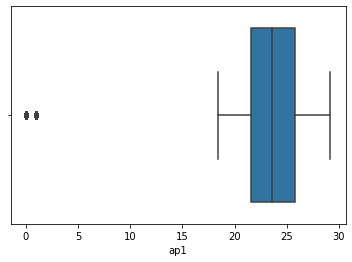

In [27]:
sns.boxplot(x=new_df['ap1'])

A fenti ábrán jól látszik, hogy a hőmérsékletek nagyrészt 22 és 27 fok között vannak, de vannak 0 és pár fokos értékek is. Ezek a normál tartományra vetítve kiugró értékeknek tűnnek.
A hőmérsékletre kiszámítjuk az IQR-t.

In [28]:
Q1 = new_df.quantile(0.25)
Q3 = new_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

kaz          4.25
er_kaz       4.25
pa4          4.25
pa2          4.25
ap1          4.25
ap3          4.25
ep1          4.25
ep3          4.25
tp1          4.25
sziv_kaz     4.25
sziv_pf      4.25
sziv_rad     4.25
sziv_hmv     4.25
sziv_jac     4.25
sziv_kal     4.25
pf_spa       4.25
hmvcirk      4.25
hmvuz        4.25
rad_phalo    4.25
tsz_pfur     4.25
rad_shalo    4.25
pf_pfur      4.25
pf_sfur      4.25
pf_tt        4.25
rad_vend     4.25
pf_vfur      4.25
pf_nap       4.25
dtype: float64


In [29]:
new_df.shape

(189957, 27)

A fenti definíció szerint kitöröljük a kiugró értékeket:

In [30]:
new_df = new_df[~((new_df < (Q1 - 1.5 * IQR)) |(new_df > (Q3 + 1.5 * IQR))).any(axis=1)]
new_df.shape

(160947, 27)

Jól látszik, hogy majdnem 30,000 érték törlődött. A boxplotot újra megjelenítve jól látszik az adattisztítás hatása. A box-plotot újra megjelenítve jól látható, hogy eltűntek a kiugró értékek.

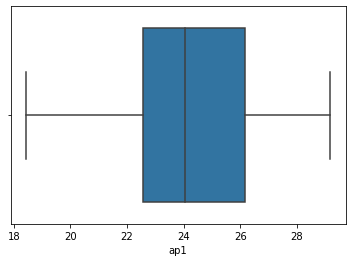

In [31]:
sns.boxplot(x=new_df['ap1'])

## Hasznos megjelenítések
A felderítő adatelemzés során gyakran vizuális elemzés az első lépés, amivel leghatékonyabban tudjuk megállapítani az adathalmaz bizonyos kulcs jellemzőit. Tipikusan két dimenzióban jelenítünk meg adatokat, akár az idő, akár két változó tekintetében.

### Hisztogram

A hisztogram egy változó értékeinek eloszlását mitatja valamilyen felosztás szerint (tipikusan egyenlő szélességű intervallumokban).
A példánkban a 10 leggyakrabban előforduló hőmérséklet értéket mutatjuk meg csökkenő sorrendben.

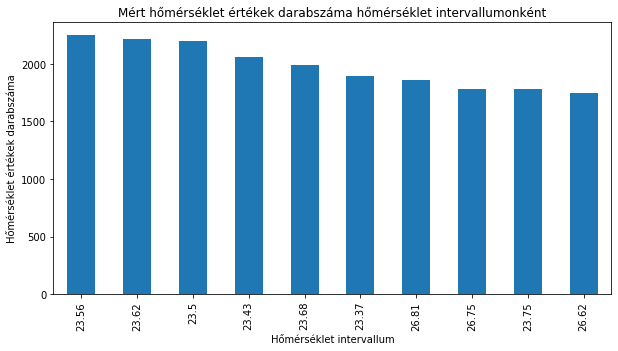

In [32]:
new_df.ap1.value_counts().nlargest(10).plot(kind='bar', figsize=(10,5))
plt.title("Mért hőmérséklet értékek darabszáma hőmérséklet intervallumonként")
plt.ylabel("Hőmérséklet értékek darabszáma")
plt.xlabel("Hőmérséklet intervallum");


### Hőtérképek

A hőtérképek használata nagy segítséget nyújt függő változók beazonosításában.
Jelen esetben egy vezérlőegység összefüggő adataival dolgozunk, így a korrelációs mátrix cellái egyeseket tartalmaznak, ebben az esetben a hőtérkép nem releváns.
A vizuális kiértékeléshez lényegesen kevesebb változóval érdemes dolgozni, 27 változó nehezen áttekinthető.

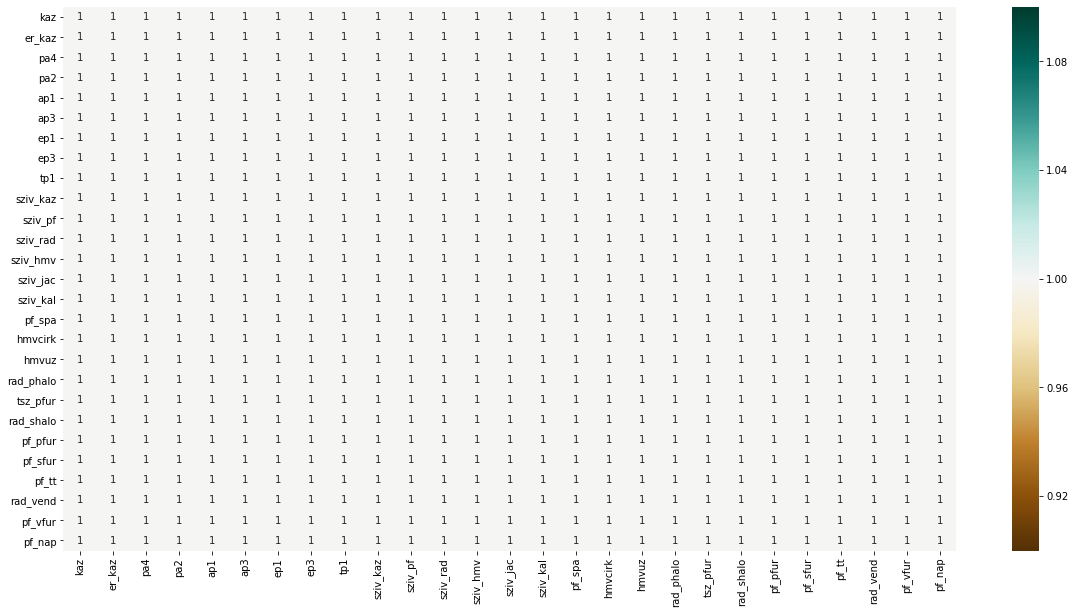

In [33]:
plt.figure(figsize=(20,10))
c= new_df.corr()
sns.heatmap(c,cmap="BrBG",annot=True)

### Scatterplot

A scatter plotot általában változók közti korreláció beazonosítására használjuk.
A plotra trendvonalak rajzolhatóak. A jelen esetben a hőmérséklet és a kazánvezérlés között 1-es a korreláció, így a scatter plot magát a trendvonalat adja.

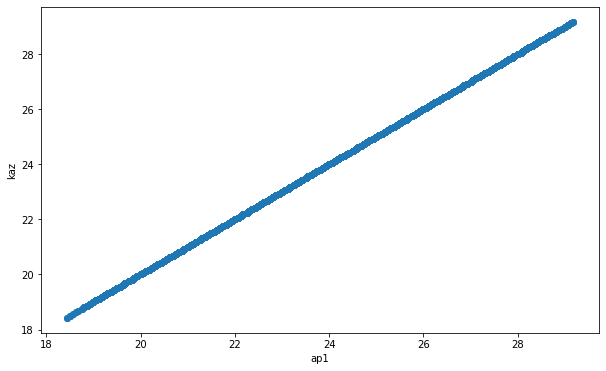

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(new_df['ap1'], new_df['kaz'])
ax.set_xlabel('ap1')
ax.set_ylabel('kaz')
plt.show()